In [1]:
import pandas as pd

# Load the pipe-separated data
df = pd.read_csv('../data/raw/insurance_data.txt', sep='|')


C:\Users\mike\AppData\Local\Temp\ipykernel_18260\4012117072.py:4: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/insurance_data.txt', sep='|')


In [19]:
# Import libraries

import pandas as pd

# Get some insights about the data
print(df.head())
print(df.info())
print(df.describe())
print(df.dtypes)
print(df.isna().sum())

   UnderwrittenCoverID  PolicyID TransactionMonth  IsVATRegistered  \
0               145249     12827       2015-03-01             True   
1               145249     12827       2015-05-01             True   
2               145249     12827       2015-07-01             True   
3               145255     12827       2015-05-01             True   
4               145255     12827       2015-07-01             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...             Mobility - Windscreen    Windscreen

In [ ]:
# Parse date columns

df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'])

In [ ]:
#  Drop unnecessary columns with too many missing values
df.drop(columns=['NumberOfVehiclesInFleet', 'CrossBorder'], inplace=True)

#  impute some columns with missing value as unknown
for col in ['Bank', 'AccountType']:
    df[col].fillna('Unknown', inplace=True)

#  impute columns with Not specified
for col in ['MaritalStatus', 'Gender']:
    df[col].fillna('Not specified', inplace=True)

# Impute column with mode
df['CapitalOutstanding'].fillna(df['CapitalOutstanding'].mode()[0], inplace=True)


# Drop rows with missing values < 1%
df.dropna(subset=['mmcode', 'make', 'Model', 'VehicleIntroDate', 'bodytype', 'kilowatts','NumberOfDoors', 'cubiccapacity', 'Cylinders', 'VehicleType'], inplace=True)

# For CustomValueEstimate — if too risky, you may still drop
# df.drop(columns=['CustomValueEstimate'], inplace=True)


In [ ]:
# impute CustomValueEstimate column with median from the same corresponding make, model and registration year
 
# Group median by Make, Model, RegistrationYear
group_median = (
    df.groupby(['make', 'Model', 'RegistrationYear'])['CustomValueEstimate']
    .median()
    .reset_index()
    .rename(columns={'CustomValueEstimate': 'GroupMedianValue'})
)

# Merge back into main dataframe
df = df.merge(group_median, on=['make', 'Model', 'RegistrationYear'], how='left')

# Fill missing CustomValueEstimate using group median
df['CustomValueEstimate'] = df['CustomValueEstimate'].fillna(df['GroupMedianValue'])

# Drop the helper column
df.drop(columns=['GroupMedianValue'], inplace=True)

# Fill any remaining with global median
#df['CustomValueEstimate'].fillna(df['CustomValueEstimate'].median(), inplace=True)


In [ ]:
# Save cleaned data
df.to_csv('../data/processed/processed_insurance_data.csv', index=False)

In [20]:
df.describe(include='all').T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
UnderwrittenCoverID,999546.0,NaN,NaN,NaN,104805.801864,1.0,55128.0,94073.0,139190.0,301175.0,63297.183277
PolicyID,999546.0,NaN,NaN,NaN,7956.019722,14.0,4500.0,7071.0,11077.0,23246.0,5290.006113
TransactionMonth,999546,NaN,NaN,NaN,2015-02-28 10:32:53.278267136,2013-10-01 00:00:00,2015-01-01 00:00:00,2015-04-01 00:00:00,2015-06-01 00:00:00,2015-08-01 00:00:00,NaN
IsVATRegistered,999546,2,False,994523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Citizenship,999546,4,,894658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LegalType,999546,6,Individual,911609,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,999546,5,Mr,933003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Language,999546,1,English,999546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bank,999546,12,First National Bank,260811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AccountType,999546,4,Current account,597706,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculate Loss ratio

import numpy as np

df['LossRatio'] = np.where(
    df['TotalPremium'] > 0,
    df['TotalClaims'] / df['TotalPremium'],
    np.nan  # don't compute if no revenue
)

df['LossRatio'].isna().sum()

np.int64(381588)

In [ ]:
# Number of rows with zero premiums
zero_premium_rows = df[df['TotalPremium'] == 0]
print(f"Zero premium rows: {len(zero_premium_rows)}")


Zero premium rows: 381302


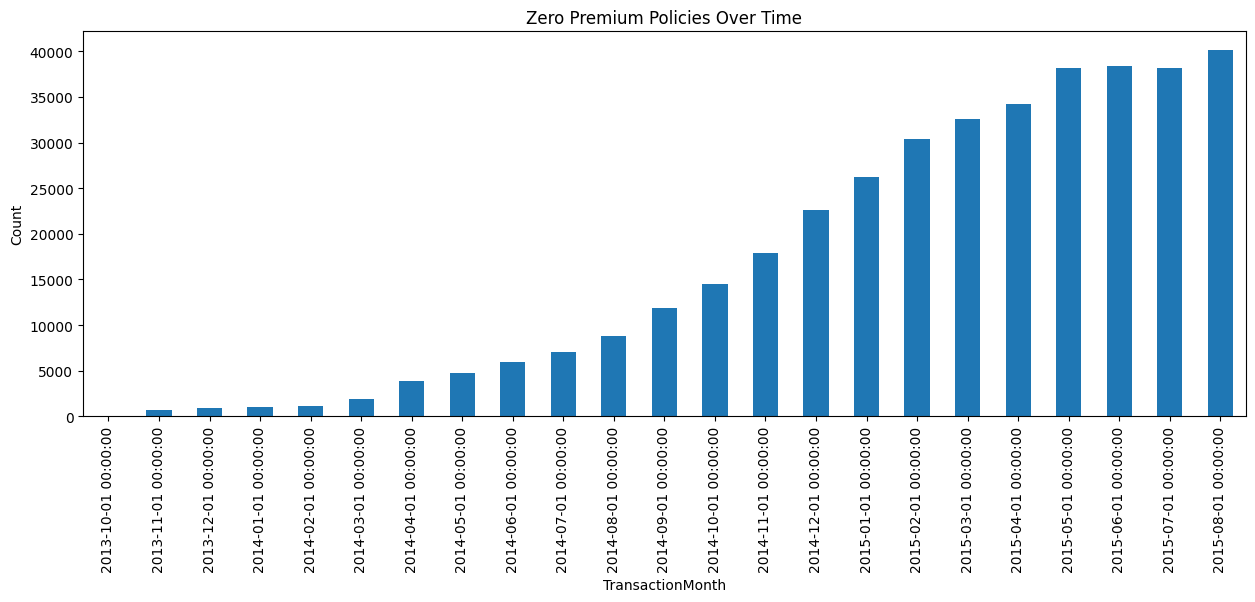

In [ ]:
# Plot for zero premiums over time

import matplotlib.pyplot as plt

df[df['TotalPremium'] == 0]['TransactionMonth'].value_counts().sort_index().plot(kind='bar', figsize=(15,5))
plt.title('Zero Premium Policies Over Time')
plt.ylabel('Count')
plt.show()


In [ ]:
# Total claims for zero premiums

zero_claims = df[df['TotalPremium'] == 0]['TotalClaims'].sum()
print(f"Total Claims for Zero Premium Policies: {zero_claims}")

Total Claims for Zero Premium Policies: 2794475.5317543857


In [53]:
# save new flag column for Zero premiums for later analysis

df['ZeroPremiumFlag'] = (df['TotalPremium'] == 0).astype(int)

In [ ]:
# Risky policies with claims but no premiums

df_risky = df[(df['TotalPremium'] == 0) & (df['TotalClaims'] > 0)]
print(f"Risky policies with claims but no premiums: {len(df_risky)}")


Risky policies with claims but no premiums: 147


c:\Users\mike\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


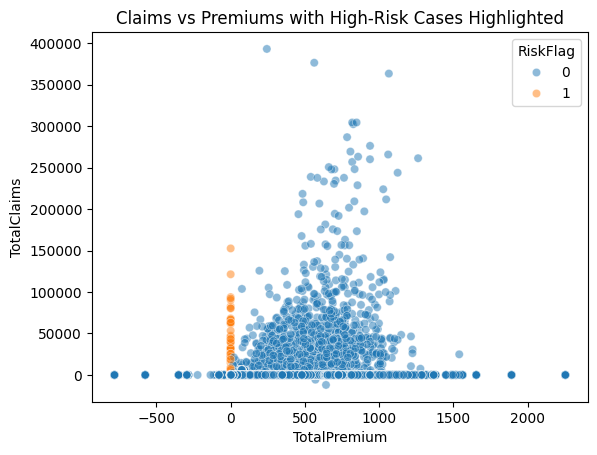

In [ ]:
#  Plot Claims vs Premiums

import seaborn as sns

df['RiskFlag'] = np.where((df['TotalPremium'] == 0) & (df['TotalClaims'] > 0), 1, 0)

sns.scatterplot(data=df, x='TotalPremium', y='TotalClaims', hue='RiskFlag', alpha=0.5)
plt.title("Claims vs Premiums with High-Risk Cases Highlighted")
plt.show()

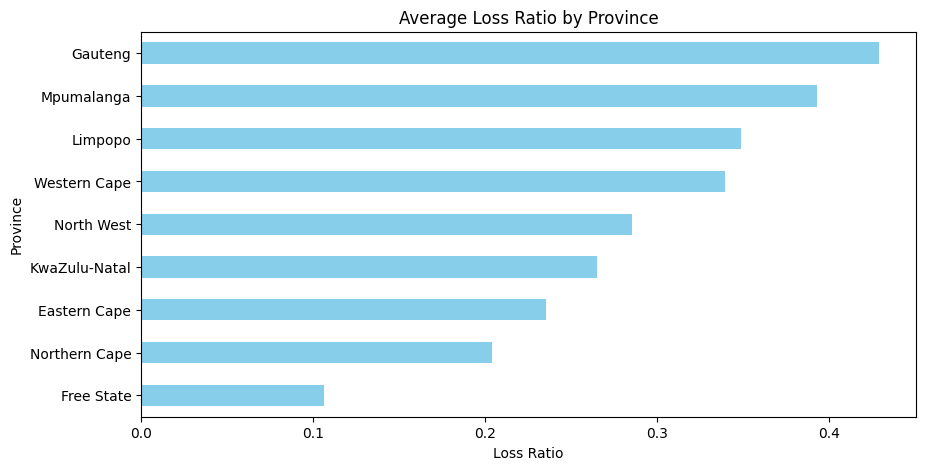

In [ ]:
#  Visualize Loss Ratio by Province

province_loss = df.groupby('Province')['LossRatio'].mean().sort_values()

plt.figure(figsize=(10, 5))
province_loss.plot(kind='barh', color='skyblue')
plt.title('Average Loss Ratio by Province')
plt.xlabel('Loss Ratio')
plt.ylabel('Province')
plt.show()


C:\Users\mike\AppData\Local\Temp\ipykernel_18260\2196325868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_loss.index, y=gender_loss.values, palette='Set2')


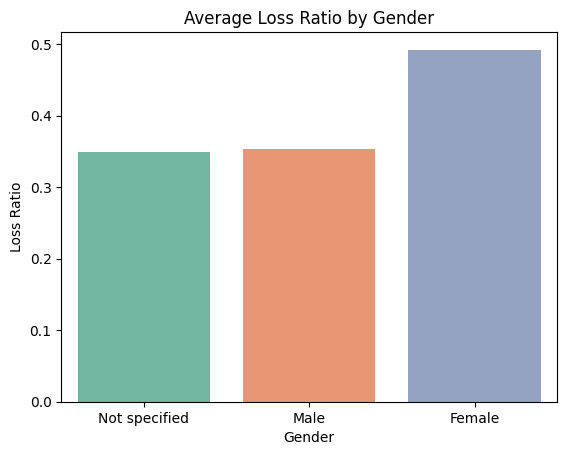

In [40]:
# Visualize Loss Ratio by gender

gender_loss = df.groupby('Gender')['LossRatio'].mean().sort_values()

sns.barplot(x=gender_loss.index, y=gender_loss.values, palette='Set2')
plt.title('Average Loss Ratio by Gender')
plt.ylabel('Loss Ratio')
plt.xlabel('Gender')
plt.show()


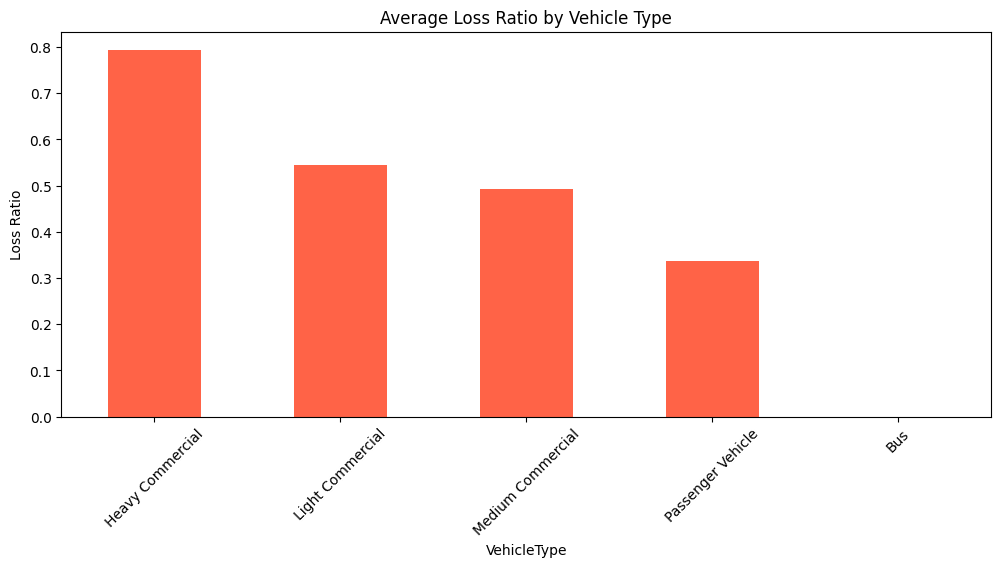

In [ ]:
# Visualize Loss Ratio by vehicle type

vehicle_loss = df.groupby('VehicleType')['LossRatio'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
vehicle_loss.plot(kind='bar', color='tomato')
plt.title('Average Loss Ratio by Vehicle Type')
plt.ylabel('Loss Ratio')
plt.xticks(rotation=45)
plt.show()


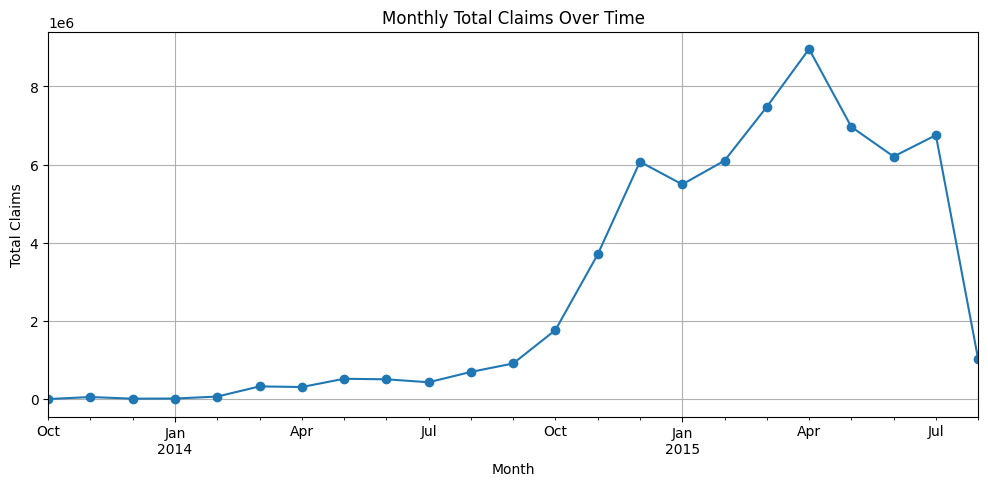

In [ ]:
#  Time Trends in Claims

monthly_claims = df.groupby(df['TransactionMonth'].dt.to_period('M'))['TotalClaims'].sum()

monthly_claims.index = monthly_claims.index.to_timestamp()

monthly_claims.plot(figsize=(12, 5), marker='o')
plt.title('Monthly Total Claims Over Time')
plt.xlabel('Month')
plt.ylabel('Total Claims')
plt.grid(True)
plt.show()


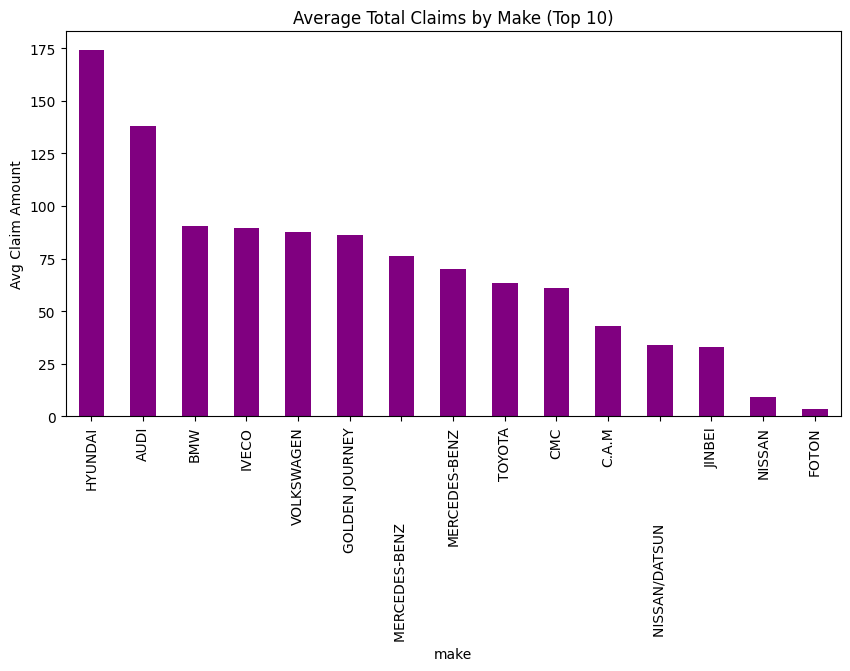

In [ ]:
#  Claim Severity by Make/Model

top_makes = df['make'].value_counts().head(15).index

make_severity = df[df['make'].isin(top_makes)].groupby('make')['TotalClaims'].mean().sort_values(ascending=False)

make_severity.plot(kind='bar', figsize=(10,5), color='purple')
plt.title('Average Total Claims by Make (Top 15)')
plt.ylabel('Avg Claim Amount')
plt.show()


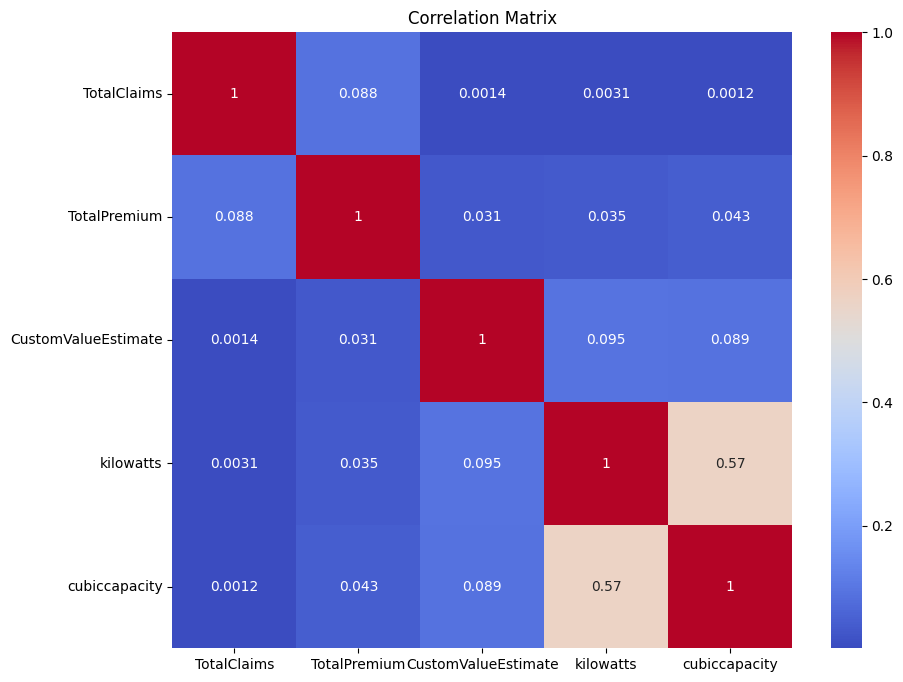

In [52]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['TotalClaims', 'TotalPremium', 'CustomValueEstimate', 'kilowatts', 'cubiccapacity']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
